# **Bayesian Nonparametrics in Pyro**

---

## What are Bayesian nonparametric models?
Bayesian nonparametric models are models where the number of parameters grow freely with the amount of data provided; thus, instead of training several models that vary in complexity and comparing them, one is able to design a model whose complexity grows as more data are observed. The prototypical example of Bayesian nonparametrics in practice is the *Dirichlet Process Mixture Model* (DPMM). A DPMM allows for a practitioner to build a mixture model when the number of distinct clusters in the geometric structure of their data is unknown – in other words, the number of clusters is allowed to grow as more data is observed. This feature makes the DPMM highly useful towards exploratory data analysis, where few facets of the data in question are known; this presentation aims to demonstrate this fact.

## The Dirichlet Process (Ferguson, 1973)
Dirichlet processes are a family of probability distributions over discrete probability distributions. Formally, the Dirichlet process (DP) is specified by some base probability distribution $G_0: \Omega \to \mathbb{R}$ and a positive, real, scaling parameter commonly denoted as $\alpha$. For any disjoint union $\Omega_1, ..., \Omega_k$ of $\Omega$, and any sample $G \sim DP(G_0, \alpha)$, we have:

$$(G(\Omega_1), ..., G(\Omega_k)) \sim \text{Dir}(\alpha G_0(\Omega_1), ..., \alpha G_0(\Omega_k))$$

While quite abstract in formulation, the Dirichlet process is very useful as a prior in various graphical models. This fact becomes easier to see in the following scheme.

## The Chinese Restaurant Process (Aldous, 1985)

Imagine a restaurant with infinite tables (indexed by the positive integers) that accepts customers one at a time. The $n$th customer chooses their seat according to the following probabilities:

*   With probability $\frac{n_t}{\alpha + n - 1}$, sit at table $t$, where $n_t$ is the number of people at table $t$
*   With probability $\frac{\alpha}{\alpha + n - 1}$, sit at an empty table

If we associate to each table $t$ a draw from a base distribution $G_0$ and then associate probability mass $n_t$ to that draw, the resulting distribution over $\Omega$ is equivalent to a draw from a Dirichlet process $DP(G_0, \alpha)$. 

Furthermore, we can easily extend this to define the generative process of a nonparametric mixture model: every table $t$ that has at least one customer seated is associated with a set of cluster parameters $\theta_t$, which were themselves drawn from some base distribution $G_0$. For each new observation, first assign that observation to a table according to the above probabilities; then, that observation is drawn from the distribution parameterized by the cluster parameters for that table. If the observation was assigned to a new table, draw a new set of cluster parameters from $G_0$, and then draw the observation from the distribution parameterized by those cluster parameters.

While this formulation of a Dirichlet process mixture model is intuitive, it is also very difficult to perform inference on in a probabilistic programming framework. This motivates an alternative formulation of DPMMs, which has empirically been shown to be more conducive to inference (e.g. Blei and Jordan, 2004).

## The Stick-Breaking Method (Sethuraman, 1994)

The generative process for the stick-breaking formulation of DPMMs proceeds as follows:

* Draw $\beta_i \sim \text{Beta}(1, \alpha)$ for $i \in \mathbb{N}$
* Draw $\theta_i \sim G_0$ for $i \in \mathbb{N}$
* Construct the mixture weights $\pi$ by taking $\pi_i(\beta_{1:\infty}) = \beta_i \prod_{j<i} (1-\beta_j)$

* For each observation $n \in \{1, ..., N\}$, draw $z_n \sim \pi(\beta_{1:\infty})$, and then draw $x_n \sim f(\theta_{z_n})$

Here, the infinite nature of the Dirichlet process mixture model can more easily be seen. Furthermore, all $\beta_i$ are independent, so it is far easier to perform inference in a probabilistic programming framework.

First, we import all the modules we're going to need:

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.graphics.tsaplots import plot_acf
from tqdm.notebook import tqdm

from pyro.distributions import *
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from torch.distributions import constraints


# **Inference**


---


## Synthetic Mixture of Gaussians

We begin by demonstrating the capabilities of Dirichlet process mixture models on a synthetic dataset generated by a mixture of four 2D Gaussians:

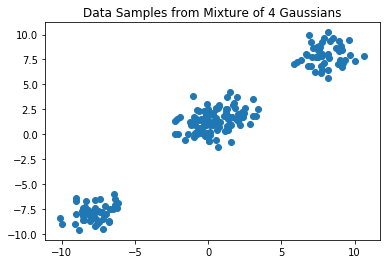

In [0]:
data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0]

In this example, the cluster parameters $\theta_i$ are two dimensional vectors describing the means of a multivariate Gaussian with identity covariance. Therefore, the Dirichlet process base distribution $G_0$ is also a multivariate Gaussian (i.e. the conjugate prior), although this choice is not as computationally useful, since we are not performing coordinate-ascent variational inference but rather black-box variational inference using Pyro. 

The variational family $q(\beta, \theta, z)$ is given by:

$$q(\beta, \theta, z) = \prod_{t=1}^{T-1} q_t(\beta_t) \prod_{t=1}^T q_t(\theta_t) \prod_{n=1}^N q_n(z_n)$$ 

Note that since we are unable to computationally model the infinite clusters posited by the model, we truncate our variational family at $T$ clusters. This does not affect our model; rather, it is a simplification made in the *inference* stage to allow tractability. 

First, let's define the "stick-breaking" function that generates our weights, given our samples of $\beta$:

In [0]:
def mix_weights(beta): 
    weights = torch.zeros(beta.shape[0] + 1)
    for t in range(beta.shape[0]):
      weights[t] = beta[t] * torch.prod(1. - beta[:t], dim=0)
    weights[beta.shape[0]] = 1. - torch.sum(weights)
    return weights

Next, let's define our model. It may be helpful to refer the definition of the stick-breaking model presented in the first part of this tutorial. 

Note that all $\beta_i$ samples are conditionally independent, so we model them using a `pyro.plate` of size `T-1`; we do the same for all samples of our cluster parameters $\mu_i$. We then construct a Categorical distribution whose parameters are the mixture weights using our sampled $\beta$ values (line 9) below, and sample the cluster assignment $z_n$ for each data point from that Categorical. Finally, we sample our observations from a multivariate Gaussian distribution whose mean is exactly the cluster parameter corresponding to the assignment $z_n$ we drew for the point $x_n$. This can be seen in the Pyro code below:

In [0]:
def model(data):
    with pyro.plate("beta_plate", T-1):
      beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
      mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
      z = pyro.sample("z", Categorical(mix_weights(beta)))
      pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)

Now, it's time to define our guide and perform inference. The guide is constructed exactly according to the definition of our variational family $q(\beta, \theta, z)$ above. We have $T-1$ conditionally independent Beta distributions for each $\beta$ sampled in our model, $T$ conditionally independent multivariate Gaussians for each cluster parameter $\mu_i$, and $N$ conditionally independent Categorical distributions for each cluster assignment $z_n$.

Our variational parameters (`pyro.param`) are therefore the $T-1$ many positive scalars that parameterize the second parameter of our variational Beta distributions (the first shape parameter is fixed at $1$, as in the model definition), the $T$ many two-dimensional vectors that parameterize our variational multivariate Gaussian distributions, and the $N$ many $T$-dimensional vectors that parameterize our variational Categorical distributions:

In [0]:
def guide(data):
    kappa = pyro.param('kappa', Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
      q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
      q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
      z = pyro.sample("z", Categorical(phi))

When performing inference, we set our 'guess' for the maximum number of clusters in the dataset to $T = 8$. We define the optimization algorithm (`pyro.optim.Adam`) along with the Pyro SVI object and train the model for 1000 iterations. Note that after performing inference, we remove any clusters that have less than a certain weight assigned to them according to our learned variational distributions, and then re-normalize the weights so that they sum to one:

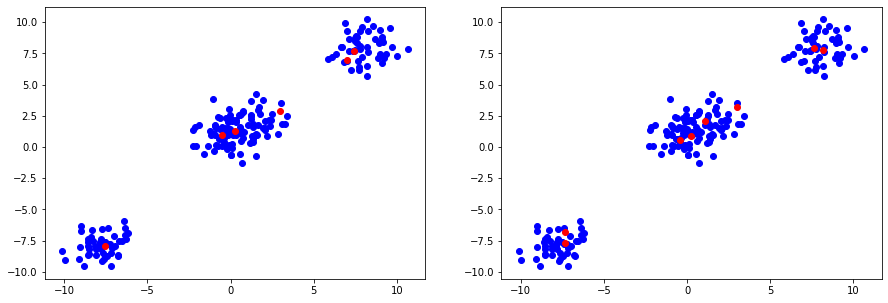

<Figure size 432x288 with 0 Axes>

In [0]:
T = 8
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.1
train(1000)
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 1.5
train(1000)
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_05[:, 0], Bayes_Centers_05[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.show()
plt.tight_layout()

The plots above demonstrate the effects of the scaling hyperparameter $\alpha$. A greater $\alpha$ yields a more heavy-tailed distribution of the weights, whereas smaller $\alpha$ will place more mass on fewer clusters. In particular, the middle cluster looks like it could be generated a single Gaussian (although in fact it was generated by two distinct Gaussians), and thus the setting of $\alpha$ allows the practitioner to further encode their prior beliefs about how many clusters the data contains.

## Dirichlet Mixture Model for Long Term Solar Observations 

As mentioned earlier, the Dirichlet process mixture model truly shines when exploring a dataset whose latent geometric structure is completely unknown. To demonstrate this, we fit a DPMM on sunspot count data taken over the past 300 years (provided by the Royal Observatory of Belgium):

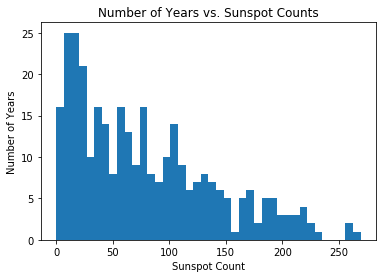

In [0]:
df = pd.read_csv('http://www.sidc.be/silso/DATA/SN_y_tot_V2.0.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32)
N = data.shape[0]

plt.hist(df['sunspot.year'].values, bins=40)
plt.title("Number of Years vs. Sunspot Counts")
plt.xlabel("Sunspot Count")
plt.ylabel("Number of Years")
plt.show()

For this example, the cluster parameters $\theta_i$ are rate parameters since we are constructing a scale-mixture of Poisson distributions. Again, $G_0$ is chosen to be the conjugate prior, which in this case is a Gamma distribution, though this still does not strictly matter for doing inference through Pyro. Below is the implementation of the model:

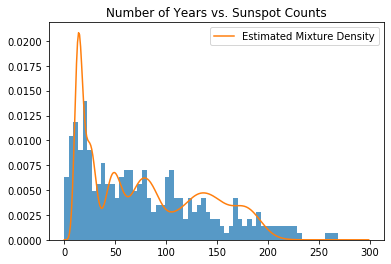

In [0]:
def model(data):
    with pyro.plate("beta_plate", T-1):
      beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("lambda_plate", T):
      lmbda = pyro.sample("lambda", Gamma(3, 0.05))
    
    with pyro.plate("data", N):
      z = pyro.sample("z", Categorical(mix_weights(beta)))
      pyro.sample("obs", Poisson(lmbda[z]), obs=data)

def guide(data):
    kappa = pyro.param('kappa', Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau_0 = pyro.param('tau_0', Uniform(0, 5).sample([T]), constraint=constraints.positive)
    tau_1 = pyro.param('tau_1', LogNormal(-1, 1).sample([T]), constraint=constraints.positive)
    phi = pyro.param('phi', Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
      q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("lambda_plate", T):
      q_lambda = pyro.sample("lambda", Gamma(tau_0, tau_1))

    with pyro.plate("data", N):
      z = pyro.sample("z", Categorical(phi))

T = 20
alpha = 1.1
n_iter = 1500
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

train(n_iter)

samples = torch.arange(0, 300).type(torch.float)

tau_optimal = zip(pyro.param("tau_0").detach(), pyro.param("tau_1").detach())
kappa_optimal = pyro.param("kappa").detach()

Bayes_Rates = np.asarray([tau0 / tau1 for tau0, tau1 in tau_optimal])
Bayes_Weights = mix_weights(1. / (1. + kappa_optimal))

def mixture_of_poisson(weights, rates, samples):
  return sum( [weights[i] * np.exp(Poisson(rates[i]).log_prob(samples)) for i in range(len(weights))] )

likelihood = mixture_of_poisson(Bayes_Weights, Bayes_Rates, samples)

plt.title("Number of Years vs. Sunspot Counts")
plt.hist(data, bins=60, density=True, lw=0, alpha=0.75);
plt.plot(samples, likelihood, label="Estimated Mixture Density")
plt.legend()
plt.show()

### ELBO Behavior

Below are plots of the behavior of the loss function (negative Trace_ELBO) over the SVI iterations during inference using Pyro, as well as a plot of the autocorrelations of the ELBO 'time series' versus iteration number. We can see that around 500 iterations, the loss stops decreasing significantly, so we can assume it takes around 500 iterations to achieve convergence. The autocorrelation plot reaches an autocorrelation very close to 0 around a lag of 400, further corroborating this hypothesis.

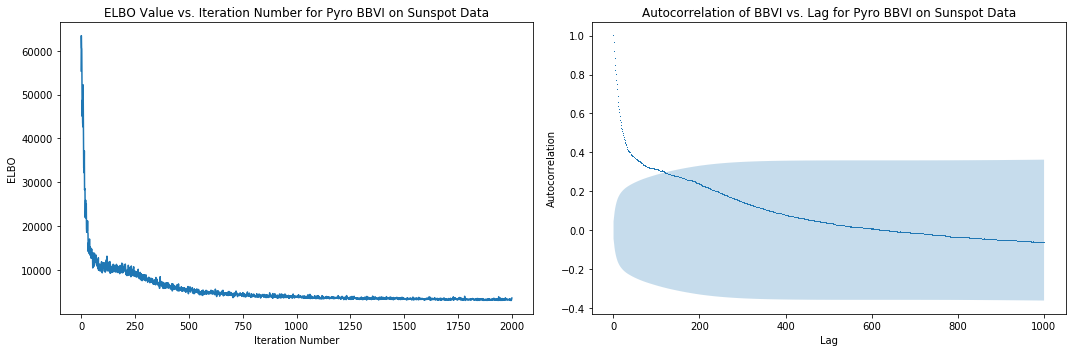

In [0]:
elbo_plot = plt.figure(figsize=(15, 5))

elbo_ax = elbo_plot.add_subplot(1, 2, 1)
elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI on Sunspot Data")
elbo_ax.set_ylabel("ELBO")
elbo_ax.set_xlabel("Iteration Number")
elbo_ax.plot(np.arange(n_iter), losses)

autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
plot_acf(np.asarray(losses), ax=autocorr_ax, lags = 750, use_vlines=False, marker=',')
autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI on Sunspot Data")
autocorr_ax.set_xlabel("Lag")
autocorr_ax.set_ylabel("Autocorrelation")
elbo_plot.tight_layout()
elbo_plot.show()


# **Criticism**

---



## Long-Term Sunspot Model

Since we computed the approximate posterior of the DPMM that was fit to the long-term sunspot data, we can utilize some intrinsic metrics, such as the mean log predictive, posterior dispersion indices, and posterior predictive checks. Since the posterior predictive distribution for a Dirichlet process mixture model is itself a scale-mixture distribution that has an analytic approximation (Blei and Jordan, 2004), this makes it particularly amenable to the aforementioned metrics:

$$p(x_{new} | X_{1:N}, \alpha, G_0) \approx \sum_{t=1}^T \mathbb{E}_q [\pi_t(\beta)] \ \mathbb{E}_q \left[p(x_{new} | \theta_t)\right].$$

We compute these below on a holdout subset of the data, after re-training the model on a training subset. 

In [0]:
def log_posterior_predictive_eval(x_new, kappa, tau_0, tau_1, S):
    T = kappa.shape[0] + 1
    q_beta = Beta(torch.ones(T - 1), kappa)
    q_lambda = Gamma(tau_0, tau_1)
    beta_mc = q_beta.sample([S])
    lambda_mc = q_lambda.sample([S])
    log_prob = 0
    for s in range(S):
        post_pred_weights = mix_weights(beta_mc[s])
        post_pred_clusters = lambda_mc[s]
        for t in range(post_pred_clusters.shape[0]):
            log_prob -= torch.exp(
                Poisson(post_pred_clusters[t]).log_prob(x_new))
    log_prob /= S
    return log_prob


def sq_log_posterior_predictive_eval(x_new, kappa, tau_0, tau_1, S):
    T = kappa.shape[0] + 1
    q_beta = Beta(torch.ones(T - 1), kappa)
    q_lambda = Gamma(tau_0, tau_1)
    beta_mc = q_beta.sample([S])
    lambda_mc = q_lambda.sample([S])
    log_prob = 0
    for s in range(S):
        post_pred_weights = mix_weights(beta_mc[s])
        post_pred_clusters = lambda_mc[s]
        for t in range(post_pred_clusters.shape[0]):
            log_prob -= torch.exp(
                Poisson(
                    post_pred_clusters[t]).log_prob(x_new)) ** 2
    log_prob /= S
    return log_prob


Mean Log Predictive:  -0.11482847
Mean Predictive:  0.89151907


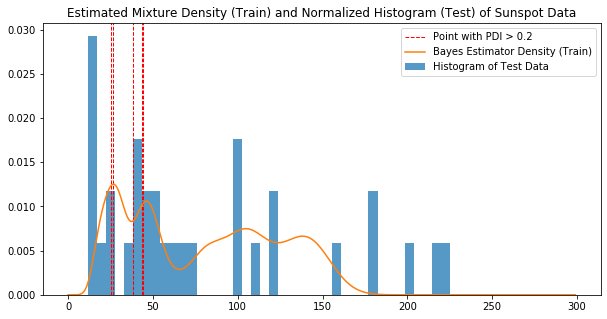

In [0]:
from sklearn.model_selection import train_test_split

data, data_test = train_test_split(df['sunspot.year'].values, test_size=0.1)
data = torch.tensor(data, dtype=torch.float)
data_test = torch.tensor(data_test, dtype=torch.float)
N = data.shape[0]
T = 20

svi = SVI(model, guide, optim, loss=Trace_ELBO())
train(500)

kappa_final = pyro.param("kappa").detach()
tau_0_final = pyro.param("tau_0").detach()
tau_1_final = pyro.param("tau_1").detach()
S = 100
N_test = data_test.shape[0]

# Mean Log Predictive
log_predictive = torch.zeros(N_test)
for idx in range(N_test):
    log_predictive[idx] += log_posterior_predictive_evaluate(data_test[idx], kappa_final, tau_0_final, tau_1_final, S)
mean_log_predictive = torch.mean(log_predictive)
print ("Mean Log Predictive: ", mean_log_predictive.numpy())
print ("Mean Predictive: ", np.exp(mean_log_predictive.numpy()))

# Posterior Dispersion Indices
pdi = []
for d in data_test:
    pdi_d = (sq_log_posterior_predictive_eval(d, kappa_final, tau_0_final, tau_1_final, S) \
              - log_posterior_predictive_eval(d, kappa_final, tau_0_final, tau_1_final, S) ** 2) \
                  / log_posterior_predictive_eval(d, kappa_final, tau_0_final, tau_1_final, S)
    pdi.append(pdi_d)
pdi = np.asarray(pdi)

Bayes_Rates = np.asarray([tau0 / tau1 for tau0, tau1 in zip(tau_0_final, tau_1_final)])
Bayes_Weights = mix_weights(1. / (1. + kappa_final))

samples = torch.arange(0, 300).type(torch.float)
likelihood_predictive = mixture_of_poisson(Bayes_Weights, Bayes_Rates, samples)

plt.figure(figsize=(10, 5))
plt.hist(data_test, bins=40, density=True, lw=0, alpha=0.75, label="Histogram of Test Data");
for pt in data_test[pdi > 0.2]:
  if pt == data_test[pdi > 0.2][0]:
    plt.axvline(pt, color='r', linestyle='dashed', linewidth=1, label="Point with PDI > 0.2") 
  else: 
    plt.axvline(pt, color='r', linestyle='dashed', linewidth=1)
plt.plot(samples, likelihood_predictive, label="Bayes Estimator Density (Train)") 
plt.title("Estimated Mixture Density (Train) and Normalized Histogram (Test) of Sunspot Data")
plt.legend()
plt.show()

The mean log predictive on the holdout set is $0.89$, which indicates that our learned mixture does a decent job at generalizing to new data. However, there are several points with posterior dispersion indices greater than $0.2$, indicating that there is a subset of the true population distribution that our mixture model is bad at modelling. 

Examining the above plot, which displays the learned density from the training set, the histogram of the test data, and dashed lines at points with high posterior dispersion indices, we can see that the modeling is doing a poor job of explaining points that are near the left tail of the distribution. Adjusting the hyperparameters on our prior base distribution $G_0$ so that it has a heavier left tail could possibly remedy this fact.

# References



1.   Ferguson, Thomas. *A Bayesian Analysis of Some Nonparametric Problems*. The Annals of Statistics, Vol. 1, No. 2 (1973). 
2.   Aldous, D. *Exchangeability and Related Topics*. Ecole diete de Probabilities Saint Flour (1985).
3.   Sethuraman, J. *A Constructive Definition of Dirichlet Priors*. Statistica, Sinica, 4:639-650 (1994).
4.   Blei, David and Jordan, Michael. *Variational Inference for Dirichlet Process Mixtures*. Bayesian Analysis, Vol. 1, No. 1 (2004).
5.   Pedregosa, et al. *Scikit-Learn: Machine Learning in Python*. JMLR 12, pp. 2825-2830 (2011).
6.   Bishop, Christopher. *Pattern Recogition and Machine Learning*. Springer Ltd (2006).
7.   *Sunspot Index and Long-Term Solar Observations*. WDC-SILSO, Royal Observatory of Belgium, Brussels (2018).


